###### Machine Learning Engineer Nanodegree

## Capstone Project

## Project: StatefarmDistracted Driver Detection 

---

---

### The Road Ahead

The notebook is broken into separate steps as shown below.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Create a CNN for Classifying Statefarm DDD Images
* [Step 2](#step2): Train a CNN with Transfer Learning Using the Bottleneck Features
* [Step 3](#step3): Train a CNN with Transfer Learning Using Fine-tuning
* [Step 4](#step4): Statefarm Kaggle Statefarm DDD Sumbmission Results

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Statefarm Distracted Driver Detection Dataset

In the code cell below, we import a dataset of driver images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split

# define function to load datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 10)
    return files, targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('imgs_train/train')

test_files, test_targets = load_dataset('imgs_test')

# load list of names
names = [item[17:19] for item in sorted(glob("imgs_train/train/*/"))]

# break training set into training and validation sets
train_files, valid_files, train_targets, valid_targets = train_test_split(train_files, train_targets, test_size=0.2, random_state=42)

# print statistics about the dataset

print('There are %s total images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training images.' % len(train_files))
print('There are %d total training categories.' % len(names))
print('There are %d validation images.' % len(valid_files))
print('There are %d test images.'% len(test_files))

Using TensorFlow backend.


There are 102150 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.
There are 79726 test images.


### Statefarm DDD Dataset Exploration

In [77]:
import pandas as pd
import numpy as np

df = pd.read_csv("driver_imgs_list.csv",header='infer')
print(df['classname'].head(3))
print(df.iloc[:,1].describe())
print("\n Image Counts")
print(df['classname'].value_counts(sort=False))

0    c0
1    c0
2    c0
Name: classname, dtype: object
count     22424
unique       10
top          c0
freq       2489
Name: classname, dtype: object

 Image Counts
c7    2002
c8    1911
c9    2129
c5    2312
c4    2326
c6    2325
c1    2267
c0    2489
c2    2317
c3    2346
Name: classname, dtype: int64


### Statefarm DDD Dataset Visualization

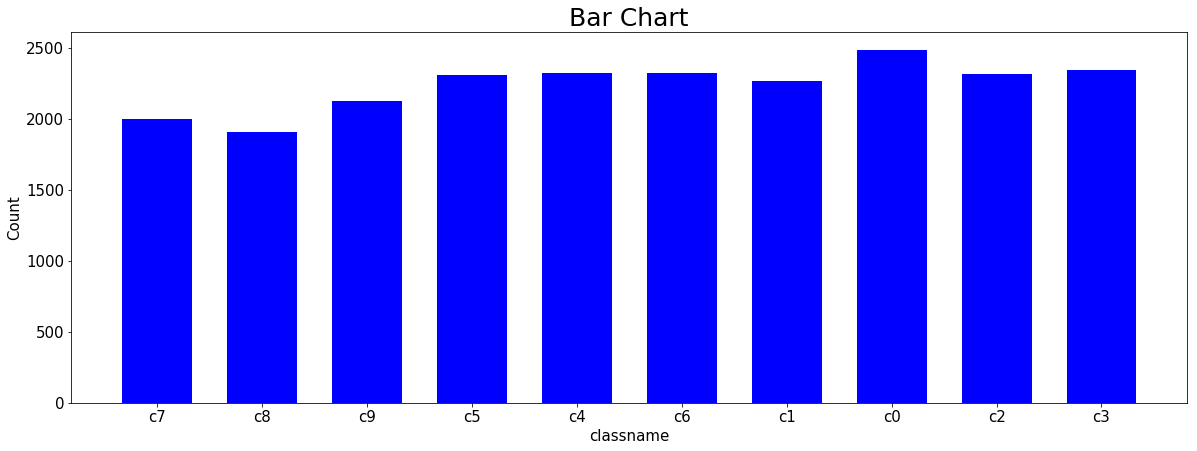

In [102]:
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

nf = df['classname'].value_counts(sort=False)
labels = df['classname'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

---
<a id='step1'></a>
## Step 1: Create a CNN to Classify Driver Images (from Scratch)



### Pre-process the Data
The Statefarm DDD images are rescaled by dividing every pixel in every image by 255. 0.5 is then subtracted to ensure that the mean is zero.

In [3]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255 - 0.5
test_tensors = paths_to_tensor(test_files).astype('float32')/255 - 0.5

100%|██████████| 79726/79726 [06:41<00:00, 198.39it/s]


### Model Architecture

A CNN is created to classify driver images.  At the end of the code cell block, the layers of the model are summarized by executing the line:
    
        model.summary()

In [4]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
#model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

### TODO: Define your architecture.

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       131328    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 512)       524800    
__________

### Compile the Model

In [6]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Statefarm DDD Model

In [7]:
from keras.callbacks import ModelCheckpoint  

epochs = 30

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=40, callbacks=[checkpointer], verbose=1)

Train on 17939 samples, validate on 4485 samples
Epoch 1/30
17939/17939 [==============================] - 306s - loss: 0.8603 - acc: 0.7153 - val_loss: 0.1467 - val_acc: 0.9565
Epoch 2/30
17939/17939 [==============================] - 246s - loss: 0.1401 - acc: 0.9577 - val_loss: 0.0522 - val_acc: 0.9844
Epoch 3/30
17939/17939 [==============================] - 242s - loss: 0.0795 - acc: 0.9771 - val_loss: 0.0548 - val_acc: 0.9846
Epoch 4/30
17939/17939 [==============================] - 245s - loss: 0.0559 - acc: 0.9838 - val_loss: 0.0277 - val_acc: 0.9931
Epoch 5/30
17939/17939 [==============================] - 244s - loss: 0.0491 - acc: 0.9868 - val_loss: 0.0253 - val_acc: 0.9926
Epoch 6/30
17939/17939 [==============================] - 241s - loss: 0.0442 - acc: 0.9885 - val_loss: 0.0338 - val_acc: 0.9918
Epoch 7/30
17939/17939 [==============================] - 244s - loss: 0.0473 - acc: 0.9872 - val_loss: 0.0188 - val_acc: 0.9960
Epoch 8/30
17939/17939 [========================

### Load the Model w/Best Validation Loss

In [8]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [6]:
test_files_final = [item_test[15:] for item_test in test_files]

### Test the Model

The model is then implemented on the test dataset of Statefarm driver images.

In [10]:
predictions = [model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in test_tensors]

In [11]:
subm = np.column_stack((np.asarray(test_files_final), np.asarray(predictions,dtype=np.float32)))

In [21]:
print(subm[1:3])

[['img_49454.jpg' '0.005046165082603693' '1.0529247447266243e-05'
  '2.0024856439704308e-07' '0.00028800248401239514' '0.0030965458136051893'
  '0.0002922963467426598' '3.092297447437886e-06' '2.205350256190286e-06'
  '0.003186901332810521' '0.9880741238594055']
 ['img_94120.jpg' '0.00017714709974825382' '4.952320331597093e-09'
  '6.329239113256335e-06' '3.2624741796993817e-10' '4.434001610320593e-09'
  '1.032989803206874e-05' '4.613828252786334e-08' '0.9997918009757996'
  '1.2984853583475342e-06' '1.3011300325160846e-05']]


### Kaggle Submission

In [12]:
np.savetxt('Submission.csv',subm, delimiter=',', comments='',  newline='\n', fmt='%s', header = 'img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9')

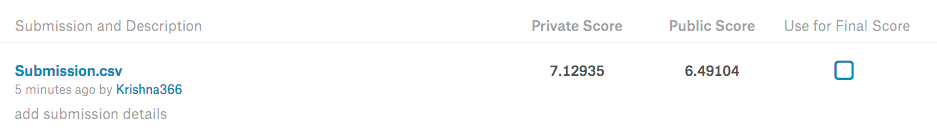

In [1]:
from IPython.display import Image
Image("Submission.png")

#### The submission into the Kaggle Statefarm DDD Competition scorer resulted in a Public Score of 6.49104. This results in a rank of 1418/1440 which equates to a represenatation in the Public Leaderboard in the top 98.47%

---
<a id='step2'></a>
## Step 2: Train a CNN with Transfer Learning - Part1

To reduce training time without sacrificing accuracy, a CNN is trained using transfer learning.  

### Using the bottleneck features of a pre-trained network

---

### Obtain Bottleneck Features

In [14]:
from keras.applications.vgg16 import VGG16
model = VGG16(include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [16]:
bottleneck_features_train_VGG16 = np.asarray([model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in train_tensors],dtype=np.float32)
#bottleneck_features_train_VGG16 = model.predict_generator(generator, nb_train_samples // batch_size)
np.save(open('bottleneck_features/bottleneck_features_train_VGG16.npy', 'wb'),bottleneck_features_train_VGG16)


bottleneck_features_valid_VGG16 = np.asarray([model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in valid_tensors],dtype=np.float32)
#bottleneck_features_train_VGG16 = model.predict_generator(generator, nb_train_samples // batch_size)
np.save(open('bottleneck_features/bottleneck_features_valid_VGG16.npy', 'wb'),bottleneck_features_valid_VGG16)


bottleneck_features_test_VGG16 = np.asarray([model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in test_tensors],dtype=np.float32)
np.save(open('bottleneck_features/bottleneck_features_test_VGG16.npy', 'wb'),bottleneck_features_test_VGG16)

In [28]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [17]:
print(bottleneck_features_train_VGG16.shape)
print(bottleneck_features_valid_VGG16.shape)
print(bottleneck_features_test_VGG16.shape)

(17939, 7, 7, 512)
(4485, 7, 7, 512)
(79726, 7, 7, 512)


### Model Architecture Version 1

The model pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 model is then fed as input into our model.  We then add a global average pooling layer & fully connected layer. The fully connected layer contains one node for each driver category and then uses an activation of softmax.

In [21]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=bottleneck_features_train_VGG16.shape[1:]))
VGG16_model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 5,130
Trainable params: 5,130
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [22]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [23]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5_transfer_learning', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(bottleneck_features_train_VGG16, train_targets, 
          validation_data=(bottleneck_features_valid_VGG16, valid_targets),
          epochs=400, batch_size=16, callbacks=[checkpointer], verbose=1)

Train on 17939 samples, validate on 4485 samples
Epoch 1/400
17939/17939 [==============================] - 7s - loss: 2.0640 - acc: 0.3635 - val_loss: 1.8389 - val_acc: 0.4916
Epoch 2/400
17939/17939 [==============================] - 6s - loss: 1.6718 - acc: 0.5994 - val_loss: 1.5223 - val_acc: 0.6553
Epoch 3/400
17939/17939 [==============================] - 6s - loss: 1.4050 - acc: 0.7011 - val_loss: 1.3083 - val_acc: 0.7041
Epoch 4/400
17939/17939 [==============================] - 6s - loss: 1.2105 - acc: 0.7553 - val_loss: 1.1383 - val_acc: 0.7670
Epoch 5/400
17939/17939 [==============================] - 7s - loss: 1.0649 - acc: 0.7950 - val_loss: 1.0029 - val_acc: 0.8107
Epoch 6/400
17939/17939 [==============================] - 6s - loss: 0.9485 - acc: 0.8183 - val_loss: 0.8971 - val_acc: 0.8348
Epoch 7/400
17939/17939 [==============================] - 7s - loss: 0.8543 - acc: 0.8403 - val_loss: 0.8122 - val_acc: 0.8508
Epoch 8/400
17939/17939 [==============================

### Load the Model with the Best Validation Loss

In [24]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5_transfer_learning')

### Test the Model

The model is tried on the test dataset of driver images.

In [25]:
# get index of predicted dog breed for each image in test set
#VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

VGG16_predictions = [VGG16_model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in bottleneck_features_test_VGG16]

# report test accuracy
#test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
#print('Test accuracy: %.4f%%' % test_accuracy)

In [26]:
VGG16_subm = np.column_stack((np.asarray(test_files_final), np.asarray(VGG16_predictions,dtype=np.float32)))

### Kaggle Submission - VGG16 Transfer Learning(Version 1)

In [27]:
np.savetxt('kaggle_submissions/VGG16_submission_1.csv',VGG16_subm, delimiter=',',comments='', newline='\n', fmt='%s', header = 'img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9')

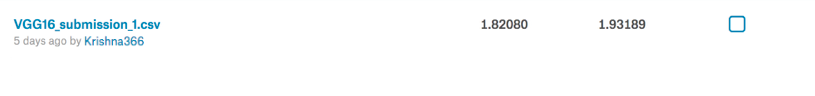

In [4]:
from IPython.display import Image
Image("Submission_1.png")

#### The submission into the Kaggle Statefarm DDD Competition scorer resulted in a Public Score of 1.93189. This results in a rank of 1120/1440 which equates to a represenatation in the Public Leaderboard in the top 77%

---
### Model Architecture Version 2

The model pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 model is then fed as input into our model. Unlike in the last model, instead of adding a global average pooling layer & fully connected layer, we add a Flatten layer and two fully connected layers. The last fully connected layer of the model contains one node for each of the driver categories and utilizes the activation softmax.



In [5]:
bottleneck_features_train2_VGG16 = np.load('bottleneck_features/bottleneck_features_train_VGG16.npy')
bottleneck_features_valid2_VGG16 = np.load('bottleneck_features/bottleneck_features_valid_VGG16.npy')
bottleneck_features_test2_VGG16 = np.load('bottleneck_features/bottleneck_features_test_VGG16.npy')

In [8]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

VGG16_model2 = Sequential()
VGG16_model2.add(Flatten(input_shape=bottleneck_features_train2_VGG16.shape[1:]))
VGG16_model2.add(Dense(500, activation='relu',kernel_initializer='glorot_normal'))
VGG16_model2.add(Dropout(0.5))
VGG16_model2.add(Dense(10, activation='softmax',kernel_initializer='glorot_normal'))

VGG16_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               12544500  
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5010      
Total params: 12,549,510
Trainable params: 12,549,510
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [11]:
VGG16_model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [33]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5_transfer_learning2', 
                               verbose=1, save_best_only=True)

VGG16_model2.fit(bottleneck_features_train2_VGG16, train_targets, 
          validation_data=(bottleneck_features_valid2_VGG16, valid_targets),
          epochs=400, batch_size=16, callbacks=[checkpointer], verbose=1)

Train on 17939 samples, validate on 4485 samples
Epoch 1/400
17939/17939 [==============================] - 21s - loss: 3.3054 - acc: 0.6021 - val_loss: 0.0753 - val_acc: 0.9775
Epoch 2/400
17939/17939 [==============================] - 21s - loss: 0.3769 - acc: 0.8922 - val_loss: 0.0879 - val_acc: 0.9784
Epoch 3/400
17939/17939 [==============================] - 21s - loss: 0.2845 - acc: 0.9284 - val_loss: 0.1422 - val_acc: 0.9625
Epoch 4/400
17939/17939 [==============================] - 21s - loss: 0.2574 - acc: 0.9436 - val_loss: 0.0461 - val_acc: 0.9931
Epoch 5/400
17939/17939 [==============================] - 21s - loss: 0.2277 - acc: 0.9512 - val_loss: 0.0968 - val_acc: 0.9826
Epoch 6/400
17939/17939 [==============================] - 21s - loss: 0.2004 - acc: 0.9587 - val_loss: 0.0388 - val_acc: 0.9938
Epoch 7/400
17939/17939 [==============================] - 21s - loss: 0.1970 - acc: 0.9619 - val_loss: 0.0318 - val_acc: 0.9949
Epoch 8/400
17939/17939 [=======================

### Load the Model with the Best Validation Loss

In [12]:
VGG16_model2.load_weights('saved_models/weights.best.VGG16.hdf5_transfer_learning2')

### Test the Model

The model is tried on the test dataset of driver images.

In [13]:
VGG16_predictions2 = [VGG16_model2.predict(np.expand_dims(tensor, axis=0))[0] for tensor in bottleneck_features_test2_VGG16]


In [16]:
VGG16_subm2 = np.column_stack((np.asarray(test_files_final), np.asarray(VGG16_predictions2,dtype=np.float32)))

### Kaggle Submission - VGG16 Transfer Learning(Version 2)

In [19]:
np.savetxt('kaggle_submissions/VGG16_submission_2.csv',VGG16_subm2, delimiter=',', comments='', newline='\n', fmt='%s', header = 'img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9')

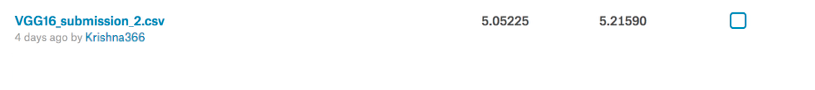

In [3]:
from IPython.display import Image
Image("Submission_2.png")

#### The submission into the Kaggle Statefarm DDD Competition scorer resulted in a Public Score of 5.21590. This results in a rank of 1415/1440 which equates to a represenatation in the Public Leaderboard in the top 98%

---
<a id='step3'></a>
## Step 3: Train a CNN with Transfer Learning - Part2

To improve accuracy, a CNN is trained using transfer learning.  

### Fine-tuning the top layers of a a pre-trained network

---
### Instantiating the VGG16 base for Fine Tuning

In [7]:
from keras.applications.vgg16 import VGG16
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense

from keras.applications.vgg16 import VGG16
base_model = VGG16(include_top=False)
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### Model Architecture Version 3

The model uses a pre-trained VGG-16 model, where the last convolutional output of VGG-16 is back into our model. In this model, we only add a global average pooling layer and a fully connected layer, where the fully connected layer contains one node for each driver category and uses the activation, softmax.

In [8]:
VGG16_top_model = Sequential()
VGG16_top_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:]))
VGG16_top_model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))


VGG16_top_model.load_weights('saved_models/weights.best.VGG16.hdf5_transfer_learning')

model = Model(input= base_model.input, output= VGG16_top_model(base_model.output))

VGG16_top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 5,130
Trainable params: 5,130
Non-trainable params: 0
_________________________________________________________________


/home/aind2/anaconda3/envs/aind2/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  


### Compile the Model

15 layers of the VGG16 model were frozen,  so the last convolutional block and fully connected layer, which is added to the top, can then be fine-tuned.

In [9]:
for layer in model.layers[:15]:
    layer.trainable = False


model.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),metrics=['accuracy'])


# Train the Model

Fine-tuning performed using slow learning rate, and SGD optimizer.  This is to ensure that the magnitude of the updates stay very small, and to not disrupt learned features in past models.

In [10]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5_fine_tuning', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=10, batch_size=16, callbacks=[checkpointer], verbose=1)

Train on 17939 samples, validate on 4485 samples
Epoch 1/10
17939/17939 [==============================] - 525s - loss: 0.1573 - acc: 0.9574 - val_loss: 0.0310 - val_acc: 0.9909
Epoch 2/10
17939/17939 [==============================] - 492s - loss: 0.0174 - acc: 0.9949 - val_loss: 0.0166 - val_acc: 0.9955
Epoch 3/10
17939/17939 [==============================] - 491s - loss: 0.0029 - acc: 0.9993 - val_loss: 0.0084 - val_acc: 0.9978
Epoch 4/10
17939/17939 [==============================] - 492s - loss: 4.5100e-04 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9975
Epoch 5/10
17939/17939 [==============================] - 492s - loss: 2.7635e-04 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9973
Epoch 6/10
17939/17939 [==============================] - 491s - loss: 2.1922e-04 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9975
Epoch 7/10
17939/17939 [==============================] - 491s - loss: 1.8479e-04 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9978
Epoch 8/10
17939/17939 [========

### Load the Model with the Best Validation Loss

In [10]:
model.load_weights('saved_models/weights.best.VGG16.hdf5_fine_tuning')

### Test the Model

The model is tried on the test dataset of driver images.

In [11]:
VGG16_predictions_fine_tuned = [model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in test_tensors]



In [12]:
VGG16_subm_fine_tuned = np.column_stack((np.asarray(test_files_final), np.asarray(VGG16_predictions_fine_tuned,dtype=np.float32)))


### Kaggle Submission - VGG16 Transfer Learning(Fine Tuning)

In [13]:
np.savetxt('kaggle_submissions/VGG16_fine_tuned_submission.csv',VGG16_subm_fine_tuned, comments='', delimiter=',', newline='\n', fmt='%s', header = 'img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9')



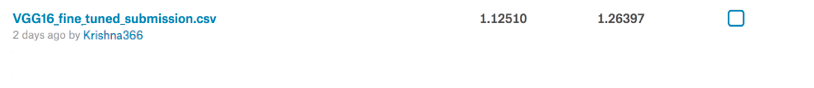

In [5]:
from IPython.display import Image
Image("Submission_Fine_Tune.png")

#### The submission into the Kaggle Statefarm DDD Competition scorer resulted in a Public Score of 1.26397. This results in a rank of 615/1440 which equates to a represenatation in the Public Leaderboard in the top 42.70%

---
<a id='step4'></a>
## Step 4: Kaggle Results

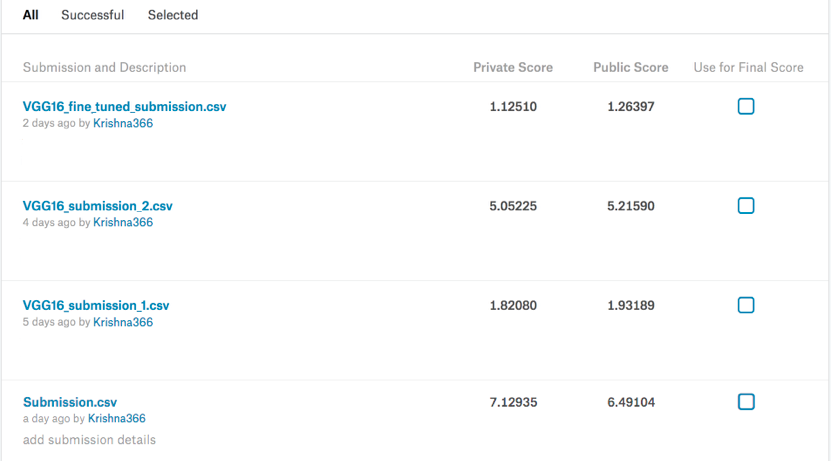

In [6]:
from IPython.display import Image
Image("Kaggle_Submissions.png")